Code written by Elisabeth Brann. This will make estimates for HI mass fractions using the method described in Li et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-4357/ac9ccb). Survival fit method from David Stark's survival fit code (https://github.com/dvstark/survival/tree/main). Survival analysis requires rpy2.

In [27]:
from astropy.io import fits
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
import os
from survival import setup, ats_fit, kaplan_meier
import matplotlib.colors
import csv
import random

Galaxy object with all needed information about a galaxy. Useful if data needs to be sorted by a parameter.

In [43]:
class galaxy_data:
    def __init__(self, idnum, calculated_mass, estimated_mass, best_guess_mass, error, ur, stellar_mass, limit, has_data, is_limit):
        self.id = idnum
        self.calculated_mass = calculated_mass
        self.estimated_mass = estimated_mass
        self.best_guess_mass = best_guess_mass
        self.error = error
        self.ur = ur
        self.stellar_mass = stellar_mass
        self.limit = limit
        self.has_data = has_data
        self.is_limit = is_limit

Opening a data file and getting the information needed for the estimates, as well as setting constants. The 'MatchedMaNGA' file refers to the HIMaNGA data (mangahi_dr3.1.fits) matched with the NASA-Sloan Atlas (NSA) catalog (nsa_v1_0_1.fits).

In [30]:
data_filename = 'MatchedMaNGA'
with fits.open(data_filename) as hdul:
    data = hdul[1].data
    MaNGAHI_data = data['LOGMHI']
    id_list = data['MANGAID']
    R50_list = data['ELPETRO_TH50_R']
    R90_list = data['ELPETRO_TH90_R']
    UR_list = data['ELPETRO_ABSMAG']
    h_stellar_mass_list = data['SERSIC_MASS']
    upper_limit = data['LOGHILIM200KMS']
    h = 1
    a = -0.42   #-0.42 ± 0.2
    b = -0.82  #-0.82 ± 0.19
    c = 0.15   #0.15 ± 0.11
    d = -2.57  #-2.57 ± 1.30
    q = 3.57   #3.57 ± 0.95
    ca = 0.10   #0.10 ± 0.08  <= Paper had a typo
    cb = -1.20  #−1.20 ± 0.76
    beta = [a, b, c, d]  # already transposed
    beta_vector = np.array(beta)

Example way of organizing the data and making the estimates. In this case, best guess mass means it is the calculated mass if present, the estimated mass if there is no calculated mass and it is below the upper limit, and otherwise the upper limit. 

In [48]:
best_guess_ids = []
best_guess_mass_list = []
best_guess_error_list = []
best_guess_UR_list = []
best_guess_stellar_mass_list = []
best_guess_limits = []
best_guess_objects_list = []

estimated_masses = []

in_bound_stellar_mass_list = []
hi_mass_list = []
above_stellar_mass_list = []
above_limit_list = []

for i in range(len(MaNGAHI_data)): 
        no_calculated_mass = False
        if MaNGAHI_data[i] <= -999 or UR_list[i][0] >= 999:
            no_calculated_mass = True
            if UR_list[i][0] >= 999:
                continue
        #calculating mean HI mass
        stellar_mass = h**2 * h_stellar_mass_list[i]
        surface_stellar_mass_density = stellar_mass/(2 * math.pi * (R50_list[i]**2))
        x = [[math.log10(surface_stellar_mass_density)], 
            [UR_list[i][2] - UR_list[i][4]], 
            [math.log10(stellar_mass)],
            [math.log10((R90_list[i]/R50_list[i]))]]
        x_vector = np.array(x)
        mean = (beta_vector.dot(x_vector) + q) + math.log10(stellar_mass) 
        #calculating error
        m0 = mean[0]
        if (m0 < 8.5): #error is constant below 8.5
            m0 = 8.5
        error = abs((ca * m0) + cb)
        estimated_masses.append(mean[0])

        # Making lists of the data
        if not no_calculated_mass:
            best_guess_ids.append(id_list[i])
            best_guess_mass_list.append(MaNGAHI_data[i])
            best_guess_error_list.append(error)
            best_guess_UR_list.append(UR_list[i][2] - UR_list[i][4])
            best_guess_stellar_mass_list.append(stellar_mass)
            best_guess_limits.append(upper_limit[i])

            hi_mass_list.append(MaNGAHI_data[i] - np.log10(stellar_mass))
            in_bound_stellar_mass_list.append(stellar_mass)
            
            ur = UR_list[i][2] - UR_list[i][4]
            galaxy = galaxy_data(id_list[i], MaNGAHI_data[i], mean[0], MaNGAHI_data[i], error, ur, stellar_mass, upper_limit[i], True, False)
            best_guess_objects_list.append(galaxy)
        if no_calculated_mass:
            # dividing galaxies with no calculated mass by whether their estimated mass 
            # is above their upper limits
            if mean[0] > upper_limit[i] and upper_limit[i] != -999.0:
                best_guess_ids.append(id_list[i])
                best_guess_mass_list.append(upper_limit[i])
                best_guess_error_list.append(error)
                best_guess_UR_list.append(UR_list[i][2] - UR_list[i][4])
                best_guess_stellar_mass_list.append(stellar_mass)
                best_guess_limits.append(upper_limit[i])

                above_stellar_mass_list.append(stellar_mass)
                above_limit_list.append(upper_limit[i] - np.log10(stellar_mass))
                
                ur = UR_list[i][2] - UR_list[i][4]
                galaxy = galaxy_data(id_list[i], MaNGAHI_data[i], mean[0], upper_limit[i], error, ur, stellar_mass, upper_limit[i], False, True)
                best_guess_objects_list.append(galaxy)
    
            else:
                best_guess_ids.append(id_list[i])
                best_guess_mass_list.append(mean[0])
                best_guess_error_list.append(error)
                best_guess_UR_list.append(UR_list[i][2] - UR_list[i][4])
                best_guess_stellar_mass_list.append(stellar_mass)
                best_guess_limits.append(upper_limit[i])
                
                ur = UR_list[i][2] - UR_list[i][4]
                galaxy = galaxy_data(id_list[i], MaNGAHI_data[i], mean[0], mean[0], error, ur, stellar_mass, upper_limit[i], False, False)
                best_guess_objects_list.append(galaxy)

Calculating statistics

In [32]:
average_estimate = statistics.fmean(estimated_masses)
standard_deviation = statistics.stdev(estimated_masses)

Below here is code for performing a survival analysis and making a fit to the best guess data made above.

Modifying the best guess data. Instead of just using the upper limit, picking a value via a guassian distribution that is below the upper limit.

In [10]:
for i in range(len(best_guess_stellar_mass_list)):
    limit = best_guess_objects_list[i].limit
    calculated_value = best_guess_objects_list[i].calculated_mass
    best_guess_param = best_guess_objects_list[i].best_guess_mass
    if ((best_guess_param != calculated_value) and (best_guess_param != limit)): #if best_guess_param is an estimate
        not_selected = True
        attempts = 0
        while(not_selected):
            selection = random.gauss(best_guess_param, standard_deviation)
            attempts = attempts + 1
            if (selection < limit):
                not_selected = False;
                best_guess_mass_list[i] = selection
            if (attempts > 500): #estimate too far off; can't find a value below the upper limit
                print("timed out...")
                not_selected = False;
                best_guess_mass_list[i] = best_guess_param

timed out...
timed out...


Survival Fit:

I don't believe what mirror you choose makes a difference; I always run with 1.

In [11]:
setup()

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 1) [https]
16: China (Beijing 2) [https]
17: China (Beijing 3) [https]
18: China (Hefei) [https]
19: China (Hong Kong) [https]
20: China (Jinan) [https]
21: China (Lanzhou) [https]
22: China (Nanjing) [https]
23: China (Shanghai 2) [https]
24: China (Shenzhen) [https]
25: China (Wuhan) [https]
26: Colombia (Cali) [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: Finland (Helsinki) [https]
33: France (Lyon 1) [https]
34: France (L

Selection:  1


R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/survival_3.8-3.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 8833756 bytes (8.4 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con


The downloaded binary packages are in
	/var/folders/df/52pxry990vq6vfrygddnd82m0000gn/T//RtmpiUwBTM/downloaded_packages


R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/NADA_1.6-1.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 490637 bytes (479 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol


The downloaded binary packages are in
	/var/folders/df/52pxry990vq6vfrygddnd82m0000gn/T//RtmpiUwBTM/downloaded_packages


In [12]:
stellar_mass_list = np.log10(best_guess_stellar_mass_list)
mass_ratio_list = []
limit_ratio_list = []
for i in range(len(best_guess_mass_list)):
    mass_ratio_list.append(best_guess_mass_list[i] - stellar_mass_list[i])
    limit_ratio_list.append(best_guess_limits[i] - stellar_mass_list[i])

This takes a couple minutes to run, so be patient. It initially prints some warnings that look like errors, but will eventually output a fit.
For example, if you see "R[write to console]: 2: package ‘stats’ is a base package, and should not be updated R[write to console]: Attaching package: ‘NADA’", that is not an error and it will produce a fit. The regular output might output NULL for the intercept, but the printed values of out will have a value for the intercept.

In [13]:
out = ats_fit(stellar_mass_list, mass_ratio_list, limit_ratio_list, fmt='(I4, 2F10.3)')
out

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In doTryCatch(return(expr), name, parentenv, handler) :
R[write to console]: 
 
R[write to console]:  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <E05F369D-F578-3218-8770-D28AA193A062> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: tried: '/opt/X11/lib/libSM.6.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/X11/lib/libSM.6.dylib' (no such file), '/opt/X11/lib/libSM.6.dylib' (no such file), '/usr/local/lib/libSM.6.dylib' (no such file), '/usr/lib/libSM.6.dylib' (no such file, not in dyld cache)

R[write to console]: 2: package ‘stats’ is a base package, and should not be updated 

R[write to console]: 
Attaching package: 

slope 
[1] -0.7691107

intercept 
NULL

tau 
[1] -0.3837301

p 
[1] 0



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :
R[write to console]: 
 
R[write to console]:  collapsing to unique 'x' values

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :
R[write to console]: 
 
R[write to console]:  collapsing to unique 'x' values

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :
R[write to console]: 
 
R[write to console]:  collapsing to unique 'x' values



{'slope': array([-0.76911074]),
 'intercept': array([7.00428833]),
 'tau': array([-0.38373011]),
 'p': array([0.]),
 'sigma_up': array([0.88628744]),
 'sigma_down': array([0.58478012])}

Example figure comparing the fit created by the survival analysis and np.polyfit.

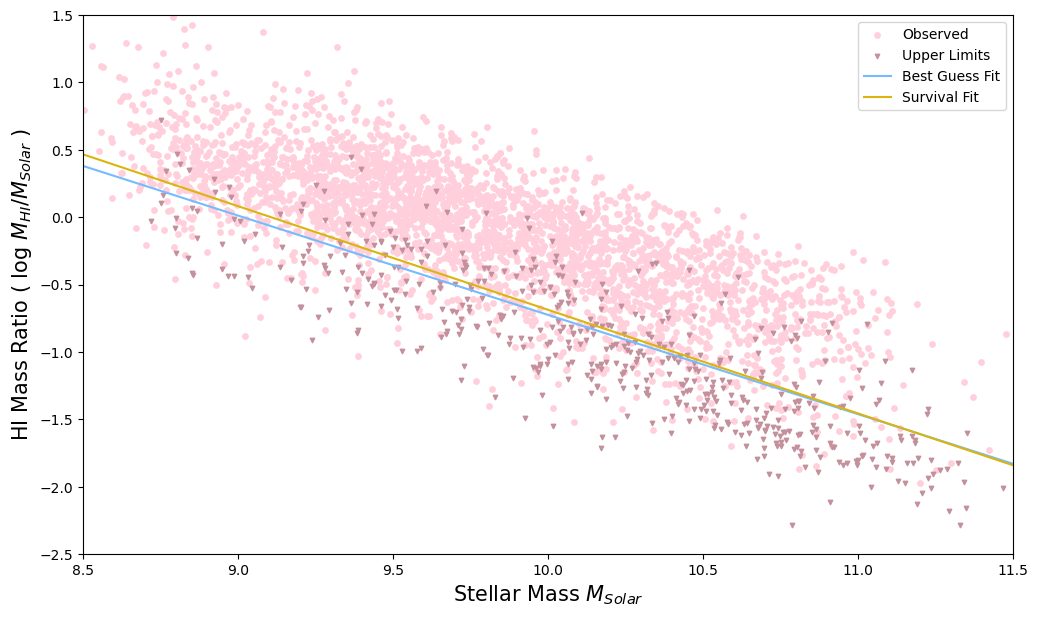

In [83]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.scatter(np.log10(in_bound_stellar_mass_list), hi_mass_list, c='xkcd:pale pink', s=15,  marker="o", label='Observed') 
ax.scatter(np.log10(above_stellar_mass_list), above_limit_list, c='xkcd:grey pink', s=10, marker = 'v', label='Upper Limits')

fit_input = np.linspace(8, 12, 100)
coefficients = np.polyfit(x=np.log10(best_guess_stellar_mass_list), y=best_guess_mass_list - stellar_mass_list, deg=1)
fit = np.poly1d(coefficients)
plt.plot(fit_input, fit(fit_input), label='Best Guess Fit', color='xkcd:sky blue')

#Plotting survival fit (values found in previous cell)
plt.plot(fit_input,(out['intercept'][0]+out['slope'][0]*fit_input), color='xkcd:gold', label='Survival Fit')
plt.xlabel('Stellar Mass $M_{Solar}$', fontsize=15)
plt.ylabel('HI Mass Ratio ( log $M_{HI}$/$M_{Solar}$ )', fontsize=15)
plt.axis([8.5, 11.5, -2.5, 1.5])
plt.legend()
plt.show()

Demo of sorting galaxies by a parameter, dividing it into classes, then fitting each class. This cell divides the galaxy object list into low, high, or average stellar mass (as well as printing the size of these divisions for reference), then zips it into lists for easy plotting.

In [90]:
low = []
mid = []
high = []
for i in range(len(best_guess_objects_list)):
    if (best_guess_objects_list[i].stellar_mass < 10**9):
        low.append(best_guess_objects_list[i])
    elif (best_guess_objects_list[i].stellar_mass > 10**11):
        high.append(best_guess_objects_list[i])
    else:
        mid.append(best_guess_objects_list[i])

print("low: ", len(low), "\nmid: ", len(mid), "\nhigh: ", len(high))

low_UR,low_HI_masses,low_stellar_mass = zip(*[(float(i.ur),float(i.best_guess_mass - np.log10(i.stellar_mass)),float(i.stellar_mass)) for i in low])
mid_UR,mid_HI_masses,mid_stellar_mass = zip(*[(float(i.ur),float(i.best_guess_mass - np.log10(i.stellar_mass)),float(i.stellar_mass)) for i in mid])
high_UR,high_HI_masses,high_stellar_mass = zip(*[(float(i.ur),float(i.best_guess_mass - np.log10(i.stellar_mass)),float(i.stellar_mass)) for i in high])

low:  484 
mid:  5754 
high:  146


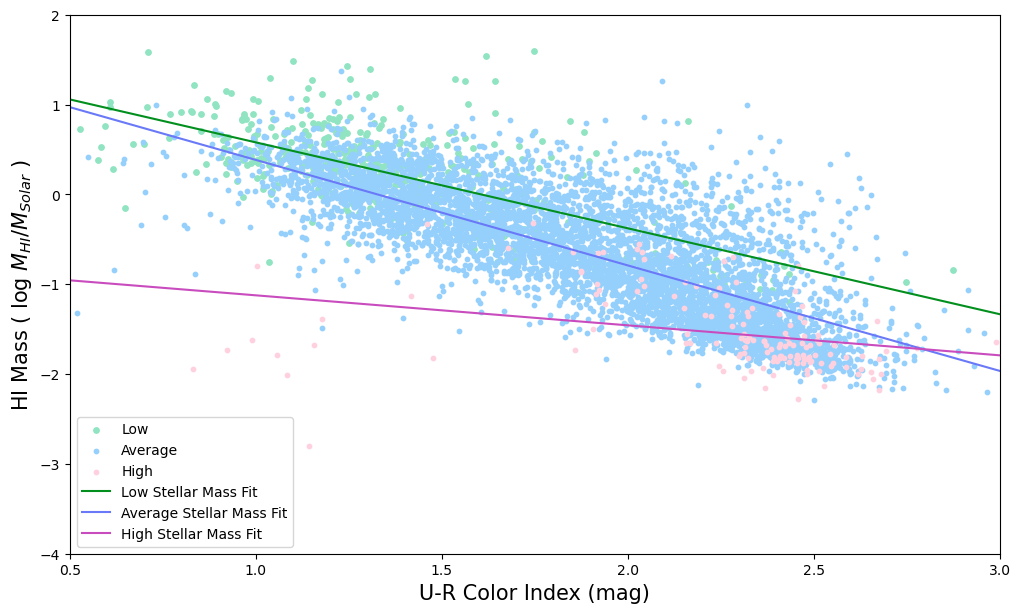

In [91]:
fig2 = plt.figure(figsize=(12, 7))
ax2 = fig2.add_subplot(111)
ax2.scatter(low_UR, low_HI_masses, c='xkcd:light teal', s=15,  marker="o", label='Low') 
ax2.scatter(mid_UR, mid_HI_masses, c='xkcd:light blue', s=10, marker = 'o', label='Average')
ax2.scatter(high_UR, high_HI_masses, c='xkcd:light pink', s=10, marker = 'o', label='High')

fit_input = np.linspace(0.5, 3, 100)
low_coefficients = np.polyfit(x=low_UR, y=low_HI_masses, deg=1)
low_fit = np.poly1d(low_coefficients)
plt.plot(fit_input, low_fit(fit_input), label='Low Stellar Mass Fit', color='xkcd:emerald green')

mid_coefficients = np.polyfit(x=mid_UR, y=mid_HI_masses, deg=1)
mid_fit = np.poly1d(mid_coefficients)
plt.plot(fit_input, mid_fit(fit_input), label='Average Stellar Mass Fit', color='xkcd:cornflower')

high_coefficients = np.polyfit(x=high_UR, y=high_HI_masses, deg=1)
high_fit = np.poly1d(high_coefficients)
plt.plot(fit_input, high_fit(fit_input), label='High Stellar Mass Fit', color='xkcd:pinky purple')

plt.xlabel('U-R Color Index (mag)', fontsize=15)
plt.ylabel('HI Mass ( log $M_{HI}$/$M_{Solar}$ )', fontsize=15)
plt.legend(loc='lower left')
#plt.axis([8.5, 11.5, 7, 10.75])
plt.axis([0.5, 3, -4, 2])

plt.legend()
plt.show()